In [1]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')

from mvesc_utility_functions import *
from estimate_prediction_model import *
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#filename = '08_12_2016_grade_10_param_set_22_RF_ht_23591'
filename = '08_17_2016_grade_10_param_set_22_RF_jg_191'

with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_RF.pkl', "rb" ) as f:
    d = pickle.load(f)
model_options = d['model_options']
d.keys()


dict_keys(['features', 'test_set_preds', 'train_set_balance', 'estimator', 'model_name', 'file_name', 'train_set_preds', 'time', 'val_set_preds', 'parameter_grid', 'test_set_soft_preds', 'train_y', 'train_set_soft_preds', 'estimator_features', 'model_options', 'val_y', 'test_y', 'val_set_soft_preds', 'cross_validation_scores'])

In [3]:
model_options['cohorts_training']

[2007, 2008, 2009, 2010, 2011]

In [4]:
model = d['estimator']

In [5]:
len(model.feature_importances_) 

94

In [34]:
outcome_plus_features = build_outcomes_plus_features(model_options,None)
outcome_plus_features.dropna(subset=[model_options['outcome_name'],
        model_options['cohort_grade_level_begin']], inplace=True)
print([a for a in outcome_plus_features.columns if 'disadvant' in a])

['disadvantagement_gr_9_academic', 'disadvantagement_gr_9_both', 'disadvantagement_gr_9_economic', 'disadvantagement_gr_9_nan']


In [33]:
train, val, test = temporal_cohort_test_split(outcome_plus_features,
            model_options['cohort_grade_level_begin'],
            model_options['cohorts_test'],
            model_options['cohorts_val'],
            model_options['cohorts_training'])
print([a for a in train_X.columns if 'disadvant' in a])

['disadvantagement_gr_9_academic', 'disadvantagement_gr_9_both', 'disadvantagement_gr_9_economic', 'disadvantagement_gr_9_nan']


In [32]:
train_X = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
test_X = test.drop([model_options['outcome_name'],
                    model_options['cohort_grade_level_begin']],axis=1)
val_X = val.drop([model_options['outcome_name'],
                  model_options['cohort_grade_level_begin']],axis=1)
train_y = train[model_options['outcome_name']]
test_y = test[model_options['outcome_name']]
val_y = val[model_options['outcome_name']]
print([a for a in train_X.columns if 'disadvant' in a])

['disadvantagement_gr_9_academic', 'disadvantagement_gr_9_both', 'disadvantagement_gr_9_economic', 'disadvantagement_gr_9_nan']


In [9]:
train_X, val_X, test_X = impute_missing_values(train_X, val_X, test_X,\
    model_options['missing_impute_strategy'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"
print([a for a in train_X.columns if 'disadvant' in a])

['disadvantagement_gr_9_academic', 'disadvantagement_gr_9_both', 'disadvantagement_gr_9_economic', 'disadvantagement_gr_9_nan']


In [10]:
train_X, val_X, test_X = scale_features(train_X, val_X, test_X,
    model_options['feature_scaling'])
assert (all(train_X.columns == test_X.columns)),\
    "train and test have different columns"
print(len(train_X.columns)) 

85


In [11]:
train_X.shape

(5445, 85)

In [12]:
binary_features = pd.DataFrame(~train_X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])

In [13]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute("""select feature,importance from model.feature_scores
                                where filename = '{}'; """.format(filename))
        temp = cursor.fetchall()
scores = pd.DataFrame(temp, columns = ['feature','importance'])
len(scores)

94

In [14]:
scores.set_index('feature', inplace=True)

In [15]:
for a in train_X.columns:
    if a not in scores.index:
        least_important = a
        print(a)
# for old models this is the least important feature, excluded from database by bug

In [16]:
for a in scores.index:
    if a not in train_X.columns:
        print(a)

disadvantagement_gr_9_none
status_gr_9_active
gender_M
disability_gr_9_none
district_gr_9_TriValley
special_ed_gr_9_0
section_504_plan_gr_9_N
ethnicity_W
limited_english_gr_9_N


In [17]:
print(len(train_X.columns)) # status_gr_9_full_college dropped 
print(len(scores)) # least important feature dropped
print(model.n_features_) # all features

85
94
94


In [18]:
scores = scores.merge(binary_features, left_index=True, right_index=True)

In [19]:
print(len(scores.index)) # dropped status_gr_9_full_college and least important feature 
print(len(train_X.columns))

85
85


/home/jgutman/env/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


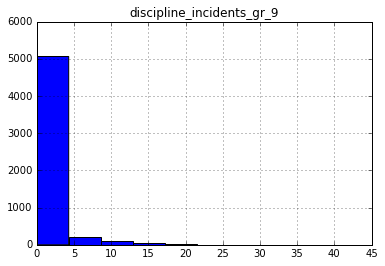

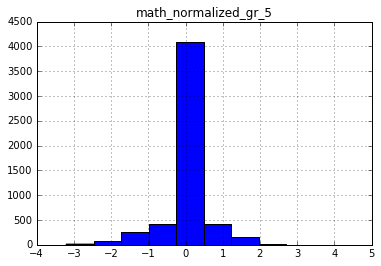

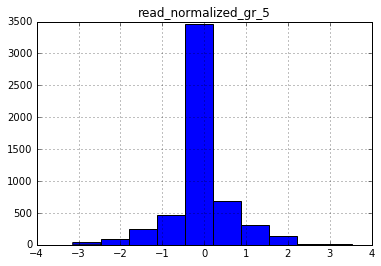

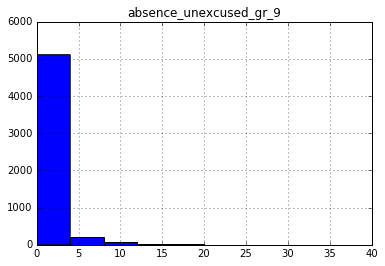

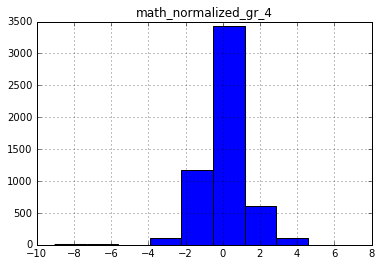

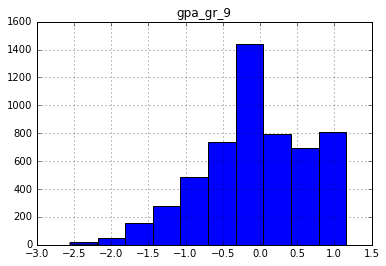

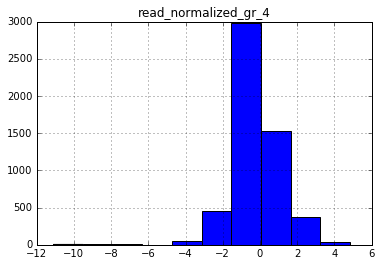

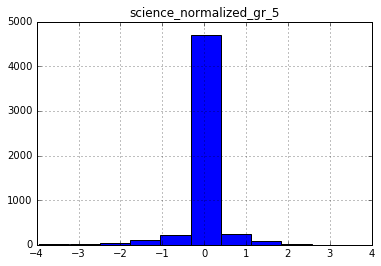

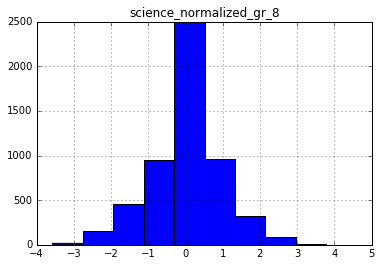

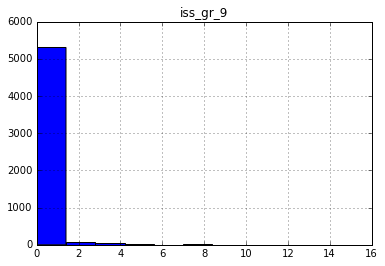

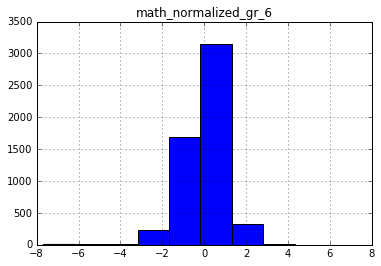

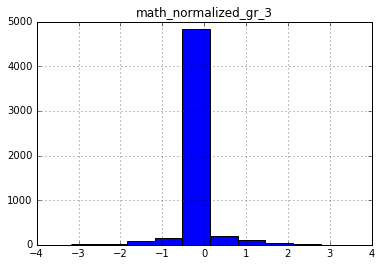

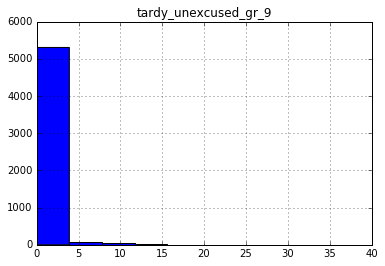

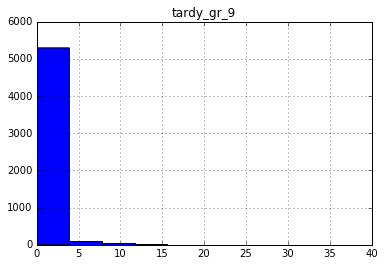

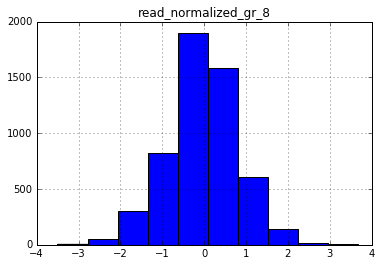

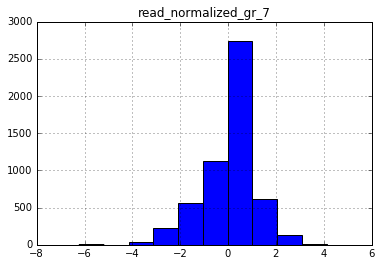

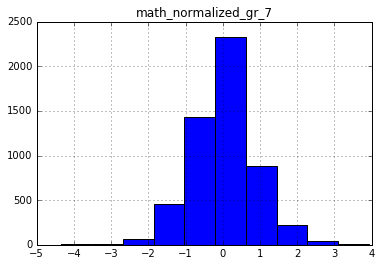

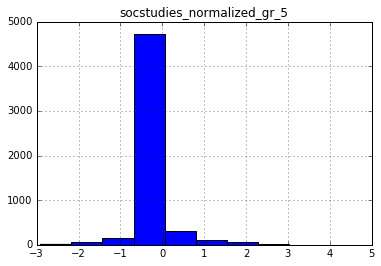

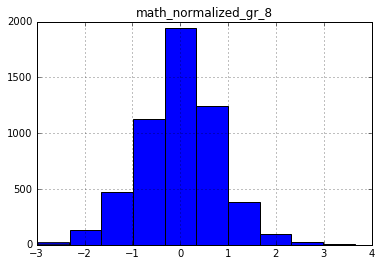

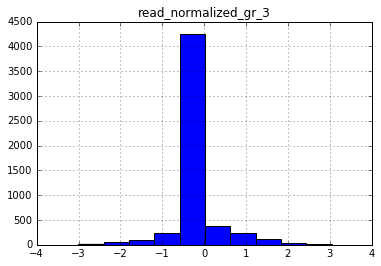

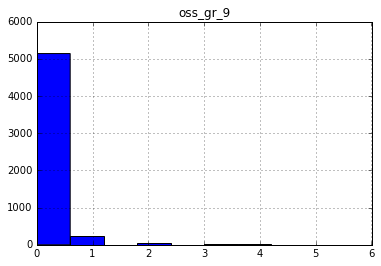

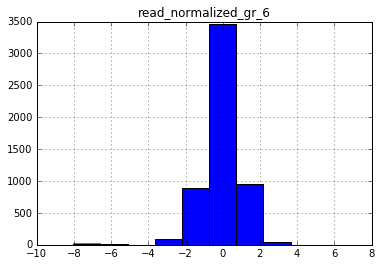

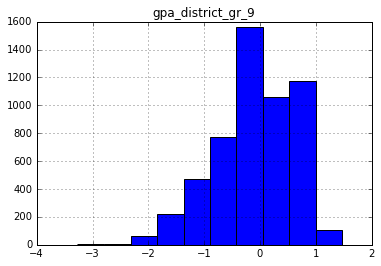

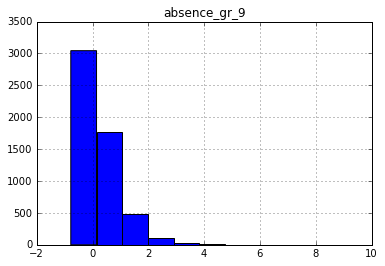

In [20]:
for c in train_X.columns[train_X.columns.isin(scores[~scores['binary']].index)]:
    plt.figure()
    train_X[c].hist()
    plt.title(c)

In [21]:
scores_weighted = scores
scores_weighted[~scores_weighted['binary']] = scores[~scores['binary']][['importance']]*5

In [22]:
scores.sort_values('importance',ascending=False)

,importance,binary
gpa_gr_9,0.395302,NaN
gpa_district_gr_9,0.395155,NaN
absence_gr_9,0.282962,NaN
math_normalized_gr_8,0.281113,NaN
read_normalized_gr_8,0.263775,NaN
math_normalized_gr_6,0.213009,NaN
math_normalized_gr_7,0.208914,NaN
science_normalized_gr_8,0.191701,NaN
read_normalized_gr_6,0.185856,NaN
math_normalized_gr_4,0.183638,NaN


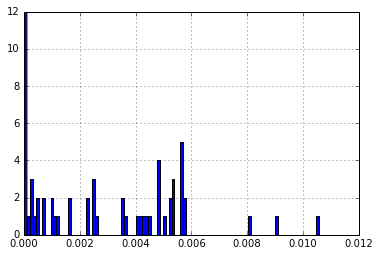

In [23]:
scores[scores['binary']==1]['importance'].hist(bins=100)

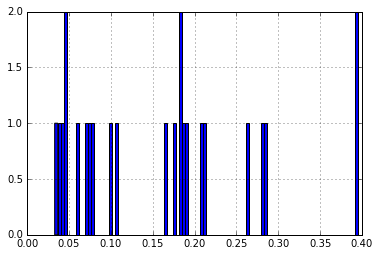

In [24]:
(scores[~(scores['binary']==1)]['importance']).hist(bins=100)

In [25]:
scores[~(scores['binary']==1)].sort_values('importance')

,importance,binary
math_normalized_gr_3,0.032830,NaN
socstudies_normalized_gr_5,0.038902,NaN
science_normalized_gr_5,0.043099,NaN
tardy_unexcused_gr_9,0.044977,NaN
tardy_gr_9,0.044980,NaN
read_normalized_gr_3,0.058510,NaN
absence_unexcused_gr_9,0.071149,NaN
math_normalized_gr_5,0.076059,NaN
iss_gr_9,0.078079,NaN
read_normalized_gr_5,0.101332,NaN


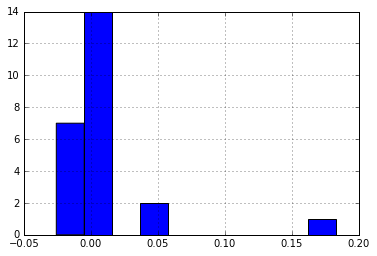

In [26]:
(train_X[train_X.columns[~(scores['binary']==1)]]*scores['importance'][~(scores['binary']==1)]).mean(axis=0).hist()


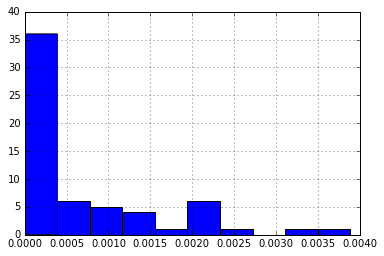

In [27]:
(train_X[train_X.columns[(scores['binary']==1)]]*scores['importance'][(scores['binary']==1)]).mean(axis=0).hist()


In [28]:
pd.DataFrame((train_X*scores['importance']).mean(axis=0), columns=['importance']).sort_values('importance', ascending=False)

,importance
discipline_incidents_gr_9,1.827115e-01
absence_gr_9,5.134544e-02
absence_unexcused_gr_9,5.040682e-02
tardy_gr_9,1.408478e-02
tardy_unexcused_gr_9,1.343106e-02
iss_gr_9,8.962228e-03
oss_gr_9,8.206434e-03
math_normalized_gr_4,6.392586e-03
math_normalized_gr_7,5.109078e-03
gender_F,3.887299e-03


In [29]:
student = 2690

In [30]:
X = train_X.loc[student]

In [31]:
shift_binary.shape

NameError: name 'shift_binary' is not defined

In [ ]:
shift_pos =  train_X[train_X.columns[~binary_features['binary']]].std()*.5
shift_neg = shift_pos*-1
shift_neg.index = [c+'_neg' for c in shift_neg.index]
shift_binary = pd.Series([-1 if x==1 else 1 for x in X[binary_features['binary']]], index = binary_features.index[binary_features['binary']])
shift_binary.columns = [c+'_binary' for c in shift_binary.columns]


In [ ]:
shift = pd.concat([shift_pos,shift_neg,shift_binary],axis=0)
X_shift = pd.DataFrame(np.tile(X.reshape([len(X),1]), len(shift)), index=X.index)
X_shift.columns = shift.index

In [ ]:
np.diag(pd.concat([shift_pos,shift_neg,shift_binary],axis=0)).shape

In [ ]:
n_steps = 100
X_student = train_X.loc[student]
X = pd.DataFrame(np.tile(X_student.reshape([len(X_student),1]),[1,n_steps]), 
                 index = X_student.index, columns = range(n_steps))
values = np.linspace(min(test_X[feature]), max(test_X[feature]), n_steps)
for i,v in enumerate(values):
    X[i].loc[feature]= v